In [1]:
## hierarchical bayesian model fitting using expectation maximization algorithom
## Adopted from Huys et al.,2011 Disentangling the roles of approach,activation and valence in instrumental and pavlovian responding. Plos Computational Biology
## Also learn from S.Gershman mfit tool: https://github.com/sjgershm/mfit

In [1]:
import numpy as np
import pandas as pd
import time
from scipy.optimize import minimize
from scipy.stats import norm
from joblib import Parallel, delayed

In [2]:
## EM Model-fitting functions
def fit_model(obj,data,bound,time):
    x0 = []
    para_name = []
    bounds = []
    for x,y in bound.items():
        x0.append(np.random.uniform(y[0],y[1],1)) 
        bounds.append((y[0],y[1]))
    result = minimize(fun=obj,x0=x0,args=data,method='L-BFGS-B',bounds=bounds)
    return result

def group_fit(obj,data,ncores,bound):
    fit_num = 30
    para_value = []
    hessian = []
    neg_llf = []
    for n in range(len(data)):
        ## parallel model-fitting
        candidate_result = Parallel(n_jobs=ncores)(delayed(fit_model)(obj,data[n],bound,i) for i in range(fit_num))
        candidate_llf = []
        for i in range(len(candidate_result)):
            candidate_llf.append(candidate_result[i].fun)
        idx = np.where(np.array(candidate_llf) == np.min(np.array(candidate_llf)))
        single_para = candidate_result[idx[0][0]].x
        single_hessian = candidate_result[idx[0][0]].hess_inv.todense()
        single_obj_fun = np.min(np.array(candidate_llf))
        para_value.append(single_para)
        hessian.append(single_hessian)
        neg_llf.append(single_obj_fun)
    return np.array(para_value),hessian,np.array(neg_llf)
        
def prior_llf(para,data):
    ## MAP estimation
    ## posterior probability of parameter is ratio to the multiplication of prior distribution of parameter and likelihood
    ## p(\theta|y) ∝ p(\theta | y) * p(\theta)
    len_para = len(para)
    llf = data['llf']
    mu = data['mu']
    sigma = data['sigma']
    fit_data = list(data.values())[:-3] ## last three elements are likelihood function, mu and sigma of the prior
    neg_llf = llf(para,fit_data)
    ## calculate posterior probability
    for n in range(len_para):
        ## Using gaussian distribution to approximate prior distribution
        neg_llf = neg_llf - np.log(norm.pdf(x = para[n], loc = mu[n], scale = sigma[n]))
    return neg_llf

def em_optim(data,llf,ncores,**bound):
    ## data: arguments for the likelihood function
    ## llf : likelihood function
    ## ncores: number of paralleled thread
    ## bound: parameter bound  
    
    ## strcutre of data: [s x 1] list, each list element is a dict which contains the necessary argument for likelihood function
    max_iter = 500 ## maximum iteration number
    tol = 0.5 ## tolerance for the EM algorithm
    pos_prob = []
    pos_prob_pre = 1e10 ## previous iteration posterior probability
        
    ## initialize the parameters of prior distribution
    para_num = len(bound.keys())
    mu = np.zeros([para_num])
    sigma = np.zeros([para_num])
    for x,y in enumerate(bound.values()):
        mu[x] = (y[1] - y[0])/2
        sigma[x] = y[1] - y[0]
    for n in range(len(data)):
        data[n]['llf'] = llf
        data[n]['mu'] = mu
        data[n]['sigma'] = sigma
    start_time = time.time()
    ## EM model fitting
    for n in range(max_iter):
        
        ## expectation step, fit model to individual subject
        para_value,hess,neg_llf = group_fit(prior_llf,data,ncores,bound)
        ## maximization step, update latent parameters
        ## calculate latent parameters
        mu = np.mean(para_value,axis = 0)
        var = np.mean(np.square(para_value) + np.array([np.diag(x) for x in hess]),axis = 0) - np.square(mu)
        ## make sure covariance matrix is a positive define matrix
        if np.min(sigma)<0:
            raise NameError('Hessian matrix is not positive defined !')
            continue
        ## update latent parameter
        for i in range(len(data)):      
            data[i]['mu'] = mu
            data[i]['sigma'] = np.sqrt(var)
        if np.absolute(np.sum(neg_llf) - pos_prob_pre)<tol:
            break
        else:
            print('Iteration '+ str(n+1)+' is done!' +'\n' + 'Difference between Target function and posterior probability is {:.2f}'.format(np.sum(neg_llf) - pos_prob_pre))
            pos_prob_pre = np.sum(neg_llf)
            pos_prob.append(np.sum(neg_llf))
    
    end_time = time.time()  
    print('EM iteration is finished !')
    print("The whole model fitting took {:.2f} seconds".format(end_time-start_time))
    return para_value,mu,pos_prob[-1]
        

In [3]:
## template of fitting a simple three parameter reinforcement learning Q-learning Model
## Q-learning function, with two candidate decision rule: epsilon softmax and softmax decision rule
def pe_cal(outcome,q_value):
    return outcome-q_value
def q_learning(outcome,alpha,q_value):
    return q_value + alpha*pe_cal(outcome,q_value)
def softmax(beta,x):
    return 1/(1+np.exp(-beta*x))
def e_softmax(beta,e,x):
    if e>1 or e<0:
        raise('ValueError')
    return e/2 + (1-e)*softmax(beta,x)
def q_learning_sim(alpha,tau,e,outcome,rule):
    trial_num = np.max(np.array(outcome.shape))
    option_num = np.min(np.array(outcome.shape))
    q_table = np.ones([option_num,trial_num+1]) * 0.5
    choice = np.zeros([trial_num])
    for n in range(trial_num):
        if rule == 'softmax':
            p = softmax(tau,q_table[1,n]-q_table[0,n])
        elif rule == 'e_softmax':
            p = e_softmax(tau,e,q_table[1,n]-q_table[0,n])
        choice[n] = np.random.binomial(1,p)
        ## update
        q_table[int(choice[n]),n+1] = q_learning(outcome[int(choice[n]),n],alpha,q_table[int(choice[n]),n])
    return choice
def q_learning_llf(para,data):
    choice,outcome,rule = data
    trial_num = np.max(np.array(outcome.shape))
    option_num = np.min(np.array(outcome.shape))
    q_table = np.ones([option_num,trial_num]) * 0.5
    if rule == 'softmax':
        alpha,tau = para
        for n in range(trial_num):
            if n==trial_num-1:
                break
            q_table[int(choice[n]),n+1] = q_learning(outcome[int(choice[n]),n],alpha,q_table[int(choice[n]),n])
    elif rule == 'e_softmax':
        alpha,tau,e = para
        for n in range(trial_num):
            if n==trial_num-1:
                break
            q_table[int(choice[n]),n+1] = q_learning(outcome[int(choice[n]),n],alpha,q_table[int(choice[n]),n])
    llf = softmax(tau,(choice*2 - 1)*(q_table[1,:]-q_table[0,:]))
    return -np.sum(np.log(llf))
def fit_model_mle(llf,choice,outcome,rule):
    fit_list = [choice,outcome,rule]
    if rule == 'softmax':
        x0 = [np.random.uniform(0,1),np.random.exponential(1)] 
        bounds = [(0.1,0.9),(0.3,10)] 
    elif rule =='e_softmax':
        x0 = [np.random.uniform(0.1,0.9),np.random.exponential(1),np.random.uniform(0.02,0.15)] 
        bounds = [(0.1,0.9),(0.3,10),(0.02,0.15)] 
    result = minimize(fun=llf,x0=x0,args=fit_list,method='L-BFGS-B',bounds=bounds)
    return result

def group_fit_mle(df,outcome,rule):
    sub_df = df.groupby('sub')
    sub_num = len(np.unique(df['sub'].to_numpy()))
    para_value=[]
    fit_num = 200
    for n in sub_df:
        fit_df  = n[1]
        obj_fun = 20000
        for i in range(fit_num):
            result = fit_model_mle(q_learning_llf,fit_df['choice'].to_numpy(),outcome,rule)
            if result.fun<obj_fun:
                fit = result.x
                obj_fun = result.fun
        para_value.append(fit) 
    return para_value

In [4]:
outcome_70 = np.random.binomial(1,0.8,50)
outcome_30 = np.random.binomial(1,0.2,50)
outcome1 = np.array([outcome_70,outcome_30])
outcome2 = np.array([outcome_30,outcome_70])
outcome = np.concatenate([outcome1,outcome2],axis=1)

In [5]:
sub_num = 50
alpha_true = np.random.uniform(0.1,0.9,sub_num)
tau_true = np.random.uniform(0.3,10,sub_num)
e_true = np.random.uniform(0.02,0.15,sub_num)
choice = np.zeros([100*sub_num])
for n in range(sub_num):
    choice[(n)*100:(n+1)*100] = q_learning_sim(alpha_true[n],tau_true[n],e_true[n],outcome,'e_softmax').astype('int')
df = pd.DataFrame({'choice':choice,'sub':np.repeat(np.arange(1,sub_num+1),100)})

In [6]:
## define data structure
data = []
for n in range(sub_num):
    sub_dict = {'choice':choice[(n)*100:(n+1)*100],'outcome':outcome,'rule':'e_softmax'}
    data.append(sub_dict)

In [7]:
indiv_para,group_mu,prob = em_optim(data,q_learning_llf,ncores=10,alpha=[0.1,0.9],tau=[0.3,10],e=[0.02,0.15])

Iteration 50 is done!
Difference between Target function and posterior probability is -9999997164.65
Iteration 50 is done!
Difference between Target function and posterior probability is 5.48
Iteration 50 is done!
Difference between Target function and posterior probability is 5.50
Iteration 50 is done!
Difference between Target function and posterior probability is -29.08
Iteration 50 is done!
Difference between Target function and posterior probability is 7.05
Iteration 50 is done!
Difference between Target function and posterior probability is 3.83
Iteration 50 is done!
Difference between Target function and posterior probability is 1.58
Iteration 50 is done!
Difference between Target function and posterior probability is 3.58
Iteration 50 is done!
Difference between Target function and posterior probability is 267.24
Iteration 50 is done!
Difference between Target function and posterior probability is -213.97
Iteration 50 is done!
Difference between Target function and posterior pr

In [8]:
## compare hierarchical bayesian estimation with maximal likelihood estimation
mle_fit = group_fit_mle(df,outcome,'e_softmax')

In [9]:
mle_fit = np.array(mle_fit)

array([[1.        , 0.78172874],
       [0.78172874, 1.        ]])

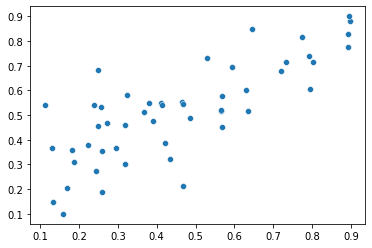

In [33]:
import seaborn as sns
sns.scatterplot(x = alpha_true,y=indiv_para[:,0])
np.corrcoef(alpha_true,indiv_para[:,0])

array([[1.        , 0.71215525],
       [0.71215525, 1.        ]])

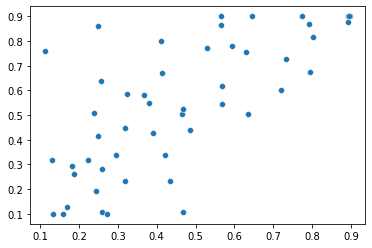

In [32]:
sns.scatterplot(x = alpha_true,y=mle_fit[:,0])
np.corrcoef(alpha_true,mle_fit[:,0])